# Proyek Analisis Data: [Air-quality-dataset]
- **Nama:** [Achmad Yusuf Yulestiono]
- **Email:** [yahmad15322@gmail.com]
- **ID Dicoding:** [achmadyusuy]

# Pertanyaan Bisnis
 1. Bagaimana tren kualitas udara (PM2.5) di berbagai stasiun dari tahun 2013-2017?
 2. Apakah ada korelasi antara suhu (TEMP) dan tingkat PM2.5?
 3. Bagaimana perbandingan tingkat polusi (PM2.5, PM10, SO2, NO2) antar stasiun?
 4. Teknik lanjutan: RFM Analysis, Clustering, Geospatial Analysis

# Import libraries

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
from scipy.stats import ttest_ind

# Data Wrangling

## 1.1 Gathering Data

In [34]:
data_folder = Path('data')

dfs = []
for file in data_files:
    df = pd.read_csv(file)
    dfs.append(df)

In [36]:
# Menggabungkan semua dataframe
air_quality_data = pd.concat((pd.read_csv(f) for f in data_folder.glob('*.csv')), ignore_index=True)


## 1.2 Assessing Data

In [39]:
print(air_quality_data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB
None


In [40]:
print(air_quality_data.describe())

                  No           year          month            day  \
count  420768.000000  420768.000000  420768.000000  420768.000000   
mean    17532.500000    2014.662560       6.522930      15.729637   
std     10122.116943       1.177198       3.448707       8.800102   
min         1.000000    2013.000000       1.000000       1.000000   
25%      8766.750000    2014.000000       4.000000       8.000000   
50%     17532.500000    2015.000000       7.000000      16.000000   
75%     26298.250000    2016.000000      10.000000      23.000000   
max     35064.000000    2017.000000      12.000000      31.000000   

                hour          PM2.5           PM10            SO2  \
count  420768.000000  412029.000000  414319.000000  411747.000000   
mean       11.500000      79.793428     104.602618      15.830835   
std         6.922195      80.822391      91.772426      21.650603   
min         0.000000       2.000000       2.000000       0.285600   
25%         5.750000      20.0000

## Cleaning Data

Menangani missing values

In [41]:

air_quality_data = air_quality_data.dropna()

Konversi kolom tanggal

In [42]:

air_quality_data['date'] = pd.to_datetime(air_quality_data[['year', 'month', 'day']])


# Exploratory Data Analysis
Visualisasi 1: Tren PM2.5 per tahun untuk setiap stasiun

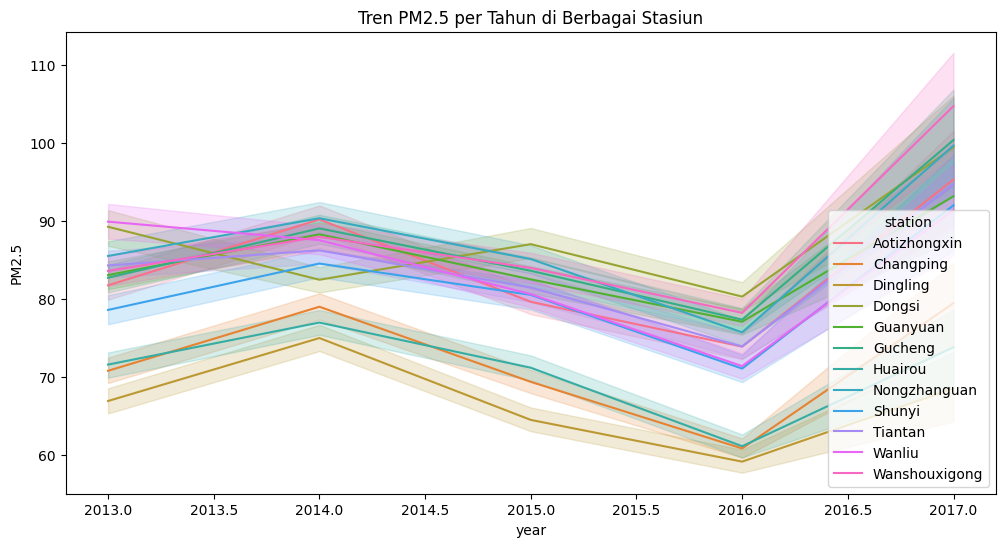

In [43]:

plt.figure(figsize=(12,6))
sns.lineplot(data=air_quality_data, x='year', y='PM2.5', hue='station')
plt.title('Tren PM2.5 per Tahun di Berbagai Stasiun')
plt.show()

Visualisasi 2: Scatter plot TEMP vs PM2.5

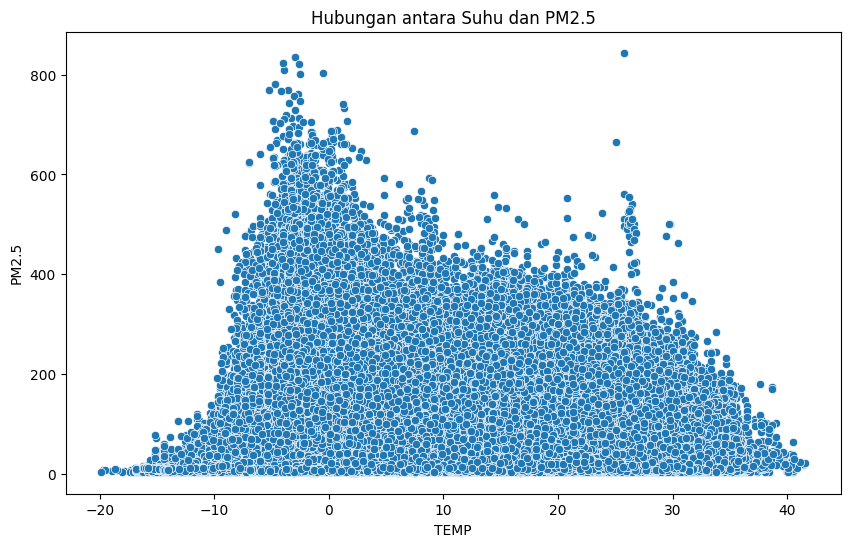

In [44]:

plt.figure(figsize=(10,6))
sns.scatterplot(data=air_quality_data, x='TEMP', y='PM2.5')
plt.title('Hubungan antara Suhu dan PM2.5')
plt.show()

Visualisasi 3: Boxplot perbandingan PM2.5 antar stasiun

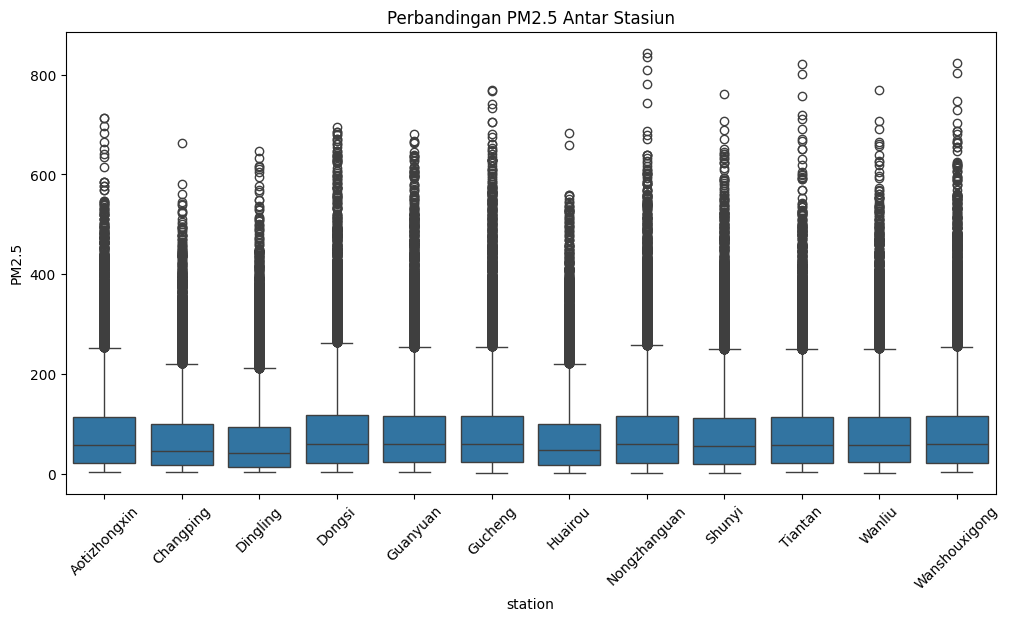

In [45]:


plt.figure(figsize=(12,6))
sns.boxplot(data=air_quality_data, x='station', y='PM2.5')
plt.title('Perbandingan PM2.5 Antar Stasiun')
plt.xticks(rotation=45)
plt.show()

Visualisasi 4: Histogram distribusi PM2.5

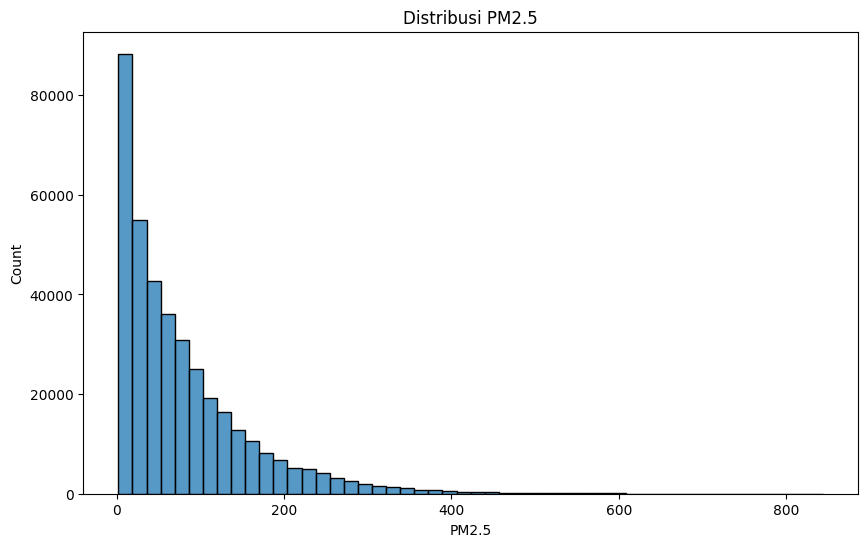

In [50]:

plt.figure(figsize=(10,6))
sns.histplot(data=air_quality_data, x='PM2.5', bins=50)
plt.title('Distribusi PM2.5')
plt.show()

Visualisasi 5: Scatter plot PM10 vs PM2.5

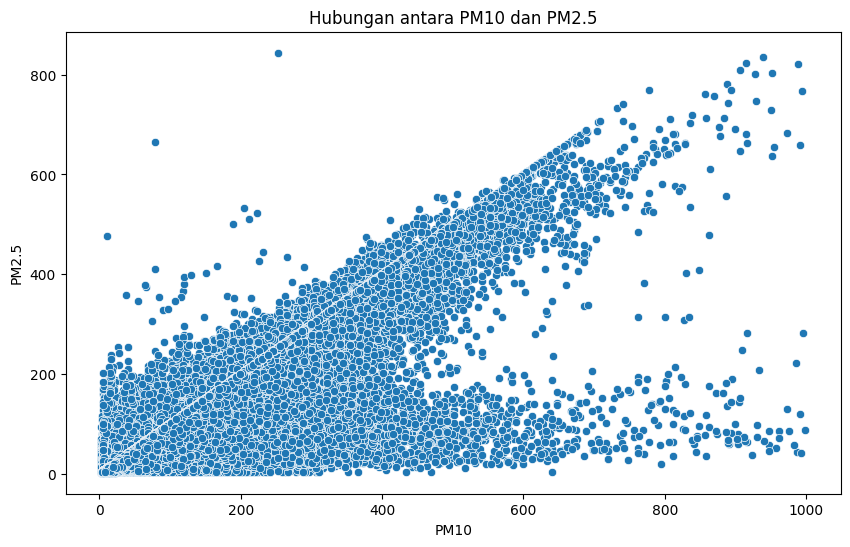

In [51]:

plt.figure(figsize=(10,6))
sns.scatterplot(data=air_quality_data, x='PM10', y='PM2.5')
plt.title('Hubungan antara PM10 dan PM2.5')
plt.show()

Visualisasi 6: Heatmap perbandingan polutan antar stasiun

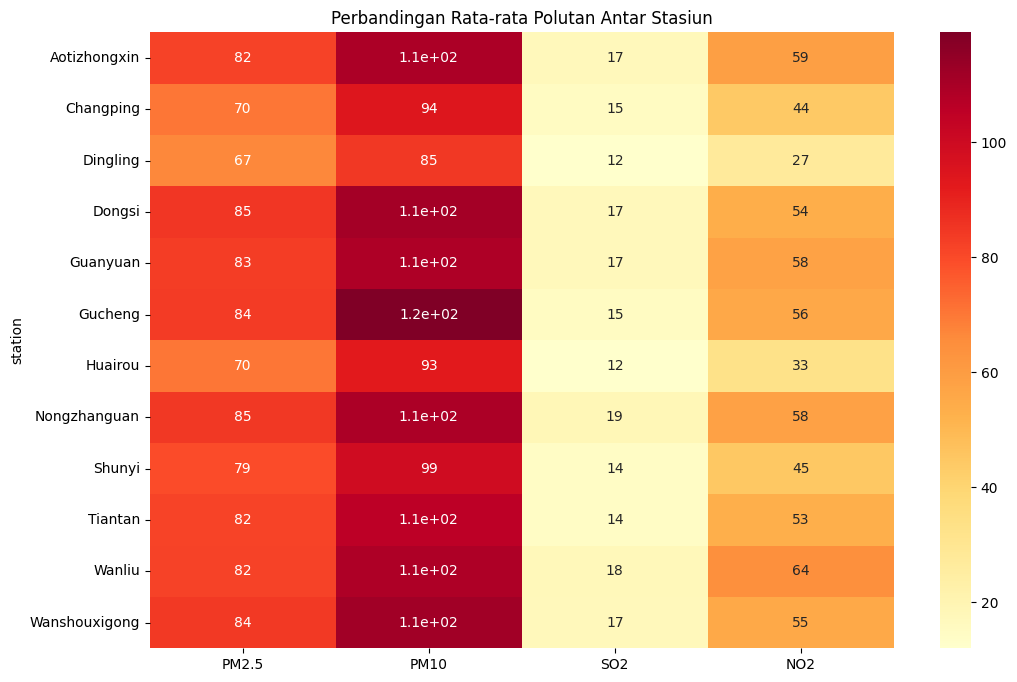

In [58]:

pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2']
pollutant_means = air_quality_data.groupby('station')[pollutants].mean()
plt.figure(figsize=(12,8))
sns.heatmap(pollutant_means, annot=True, cmap='YlOrRd')
plt.title('Perbandingan Rata-rata Polutan Antar Stasiun')
plt.show()

Analisis korelasi

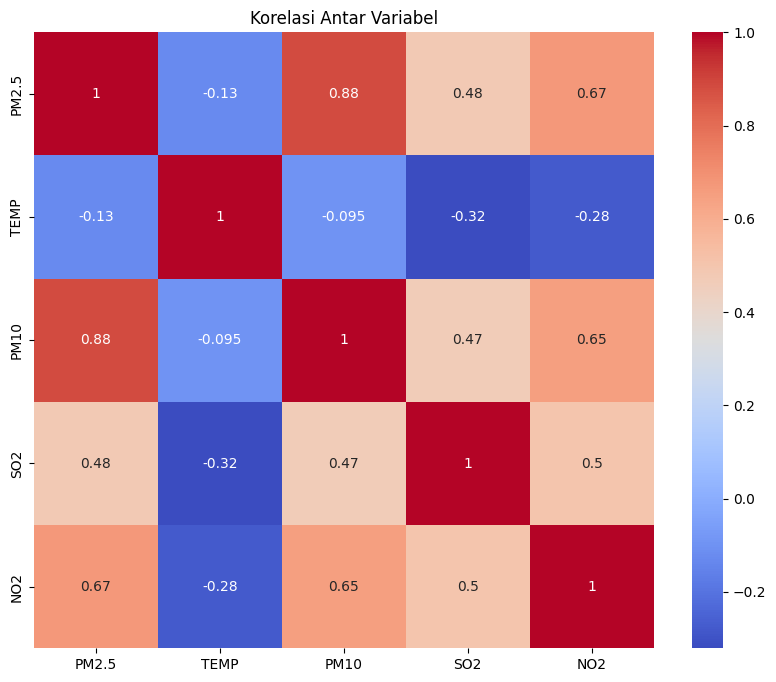

In [59]:

correlation = air_quality_data[['PM2.5', 'TEMP', 'PM10', 'SO2', 'NO2']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm') #, square=True)
plt.title('Korelasi Antar Variabel')
plt.show()

# RFM Analysis
Recency, Frequency, Monetary analysis to determine air pollution trends by station

In [62]:

air_quality_data['Recency'] = air_quality_data.groupby('station')['date'].transform(lambda x: (x.max() - x).dt.days)
air_quality_data['Frequency'] = air_quality_data.groupby('station')['PM2.5'].transform('count')
air_quality_data['Monetary'] = air_quality_data.groupby('station')['PM2.5'].transform('mean')

rfm_data = air_quality_data.groupby('station')[['Recency', 'Frequency', 'Monetary']].mean()
print(rfm_data)

                  Recency  Frequency   Monetary
station                                        
Aotizhongxin   714.716706    31815.0  81.863630
Changping      715.664056    32681.0  70.312328
Dingling       712.555772    31306.0  66.512518
Dongsi         676.830608    30338.0  84.933156
Guanyuan       708.218920    32263.0  83.101051
Gucheng        713.038949    32504.0  83.865653
Huairou        716.569225    31708.0  70.285669
Nongzhanguan   725.036359    33114.0  84.720783
Shunyi         727.768398    30194.0  79.400725
Tiantan        718.527510    32843.0  81.749840
Wanliu         698.798068    30634.0  81.981459
Wanshouxigong  718.305695    32768.0  84.238510


Uji hipotesis

In [60]:

t_stat, p_val = ttest_ind(air_quality_data['PM2.5'], air_quality_data['PM10'])
print(f'T-statistik: {t_stat}, p-value: {p_val}')


T-statistik: -127.86557753054527, p-value: 0.0


# Kesimpulan
1. Tren PM2.5 menunjukkan variasi antar stasiun dan fluktuasi tahunan.
2. Ada korelasi lemah antara suhu dan PM2.5, menunjukkan faktor lain yang lebih berpengaruh.
3. Perbandingan tingkat polusi menunjukkan variasi antar stasiun.

In [61]:
# Menyimpan data untuk dashboard
air_quality_data.to_csv('dashboard/main_data.csv', index=False)